In [1]:
import pandas as pd 
import numpy as np 
import os 
from pandas import *
from pandas.plotting import lag_plot, autocorrelation_plot
import matplotlib.pyplot as plt 
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from math import sqrt
import mysql.connector
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import pacf
from statsmodels.regression.linear_model import yule_walker
from statsmodels.tsa.stattools import adfuller
from mysql.connector import connection
import seaborn as sns 


In [2]:
connection = mysql.connector.connect(
        host=  os.environ.get('host'), 
        port=  3310,
        database = 'database_fiumi',  #'rivers_db'
        user =  os.environ.get('user'),
        password = os.environ.get('password')
        )
connection.autocommit = True
cursor = connection.cursor()

In [3]:
query = 'SELECT Timestamp, W_mean from Tabella_Isarco' 
df = pd.read_sql(query, con=connection)
print(df)

                Timestamp  W_mean
0     2019-03-29 03:00:00     NaN
1     2019-03-29 04:00:00     NaN
2     2019-03-29 05:00:00     NaN
3     2019-03-29 06:00:00     NaN
4     2019-03-29 07:00:00     NaN
...                   ...     ...
20162 2021-07-16 12:00:00  222.00
20163 2021-07-16 13:00:00  222.67
20164 2021-07-16 14:00:00  226.50
20165 2021-07-16 15:00:00  233.00
20166 2021-07-16 16:00:00  229.67

[20167 rows x 2 columns]


In [4]:
# CLEAN THE DATA
droppare = []
i = 0 
while i < (len(df['W_mean'])):
        if np.isnan(df['W_mean'].iloc[i]):
                droppare.append(i)
        i += 1

for j in droppare :
    df =  df.drop(j)

df

,Timestamp,W_mean
162,2019-04-04 23:00:00,162.00
163,2019-04-05 00:00:00,161.33
164,2019-04-05 01:00:00,163.17
165,2019-04-05 02:00:00,167.33
166,2019-04-05 03:00:00,170.67
...,...,...
20162,2021-07-16 12:00:00,222.00
20163,2021-07-16 13:00:00,222.67
20164,2021-07-16 14:00:00,226.50
20165,2021-07-16 15:00:00,233.00


In [5]:
df = df.reset_index()
df

,index,Timestamp,W_mean
0,162,2019-04-04 23:00:00,162.00
1,163,2019-04-05 00:00:00,161.33
2,164,2019-04-05 01:00:00,163.17
3,165,2019-04-05 02:00:00,167.33
4,166,2019-04-05 03:00:00,170.67
...,...,...,...
20000,20162,2021-07-16 12:00:00,222.00
20001,20163,2021-07-16 13:00:00,222.67
20002,20164,2021-07-16 14:00:00,226.50
20003,20165,2021-07-16 15:00:00,233.00


In [6]:
print(df['Timestamp'])

0       2019-04-04 23:00:00
1       2019-04-05 00:00:00
2       2019-04-05 01:00:00
3       2019-04-05 02:00:00
4       2019-04-05 03:00:00
                ...        
20000   2021-07-16 12:00:00
20001   2021-07-16 13:00:00
20002   2021-07-16 14:00:00
20003   2021-07-16 15:00:00
20004   2021-07-16 16:00:00
Name: Timestamp, Length: 20005, dtype: datetime64[ns]


In [7]:
df.describe()

,index,W_mean
count,20005.000000,20005.000000
mean,10164.000000,178.389013
std,5775.090403,41.096218
min,162.000000,104.170000
25%,5163.000000,146.000000
50%,10164.000000,173.500000
75%,15165.000000,206.330000
max,20166.000000,450.000000


In [8]:
df.columns

Index(['index', 'Timestamp', 'W_mean'], dtype='object')

In [9]:
#Create a df for the year 2019
y_19 = df.iloc[:7108]
y_19

,index,Timestamp,W_mean
0,162,2019-04-04 23:00:00,162.00
1,163,2019-04-05 00:00:00,161.33
2,164,2019-04-05 01:00:00,163.17
3,165,2019-04-05 02:00:00,167.33
4,166,2019-04-05 03:00:00,170.67
...,...,...,...
7103,7265,2020-01-25 23:00:00,136.00
7104,7266,2020-01-26 00:00:00,135.83
7105,7267,2020-01-26 01:00:00,136.00
7106,7268,2020-01-26 02:00:00,134.83


In [10]:
#Create a df for the year 2020
y_20 = df.iloc[7108:16147]
y_20

,index,Timestamp,W_mean
7108,7270,2020-01-26 04:00:00,120.17
7109,7271,2020-01-26 05:00:00,111.17
7110,7272,2020-01-26 06:00:00,109.33
7111,7273,2020-01-26 07:00:00,111.00
7112,7274,2020-01-26 08:00:00,110.67
...,...,...,...
16142,16304,2021-02-05 17:00:00,113.83
16143,16305,2021-02-05 18:00:00,110.17
16144,16306,2021-02-05 19:00:00,134.50
16145,16307,2021-02-05 20:00:00,144.50


In [11]:
#Create a df for the year 2021
y_21 = df.iloc[16147:]
y_21

,index,Timestamp,W_mean
16147,16309,2021-02-05 22:00:00,148.83
16148,16310,2021-02-05 23:00:00,143.83
16149,16311,2021-02-06 00:00:00,141.00
16150,16312,2021-02-06 01:00:00,140.17
16151,16313,2021-02-06 02:00:00,139.00
...,...,...,...
20000,20162,2021-07-16 12:00:00,222.00
20001,20163,2021-07-16 13:00:00,222.67
20002,20164,2021-07-16 14:00:00,226.50
20003,20165,2021-07-16 15:00:00,233.00


In [12]:
#tks = np.arange(min(df['Timestamp']), max(df['Timestamp']), 30)
min_time = (min(df['Timestamp']))   
max_time = (max(df['Timestamp']))
ticks = []
#tks = np.arange(min_time, max_time)
start_time = df['Timestamp'].iloc[0]
start_time = str(start_time)
start_time = start_time.split()
start_time = start_time[0]
print(start_time)
x_data = pd.date_range(start_time, periods=30, freq='MS') 
# Check how this dates looks like:
print(x_data)
for i in range(len(df)):
    ticks.append(i)
    
len(ticks)

2019-04-04
DatetimeIndex(['2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01',
               '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01',
               '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01',
               '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01',
               '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01',
               '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01'],
              dtype='datetime64[ns]', freq='MS')


20005

In [13]:
df['Timestamp']

0       2019-04-04 23:00:00
1       2019-04-05 00:00:00
2       2019-04-05 01:00:00
3       2019-04-05 02:00:00
4       2019-04-05 03:00:00
                ...        
20000   2021-07-16 12:00:00
20001   2021-07-16 13:00:00
20002   2021-07-16 14:00:00
20003   2021-07-16 15:00:00
20004   2021-07-16 16:00:00
Name: Timestamp, Length: 20005, dtype: datetime64[ns]

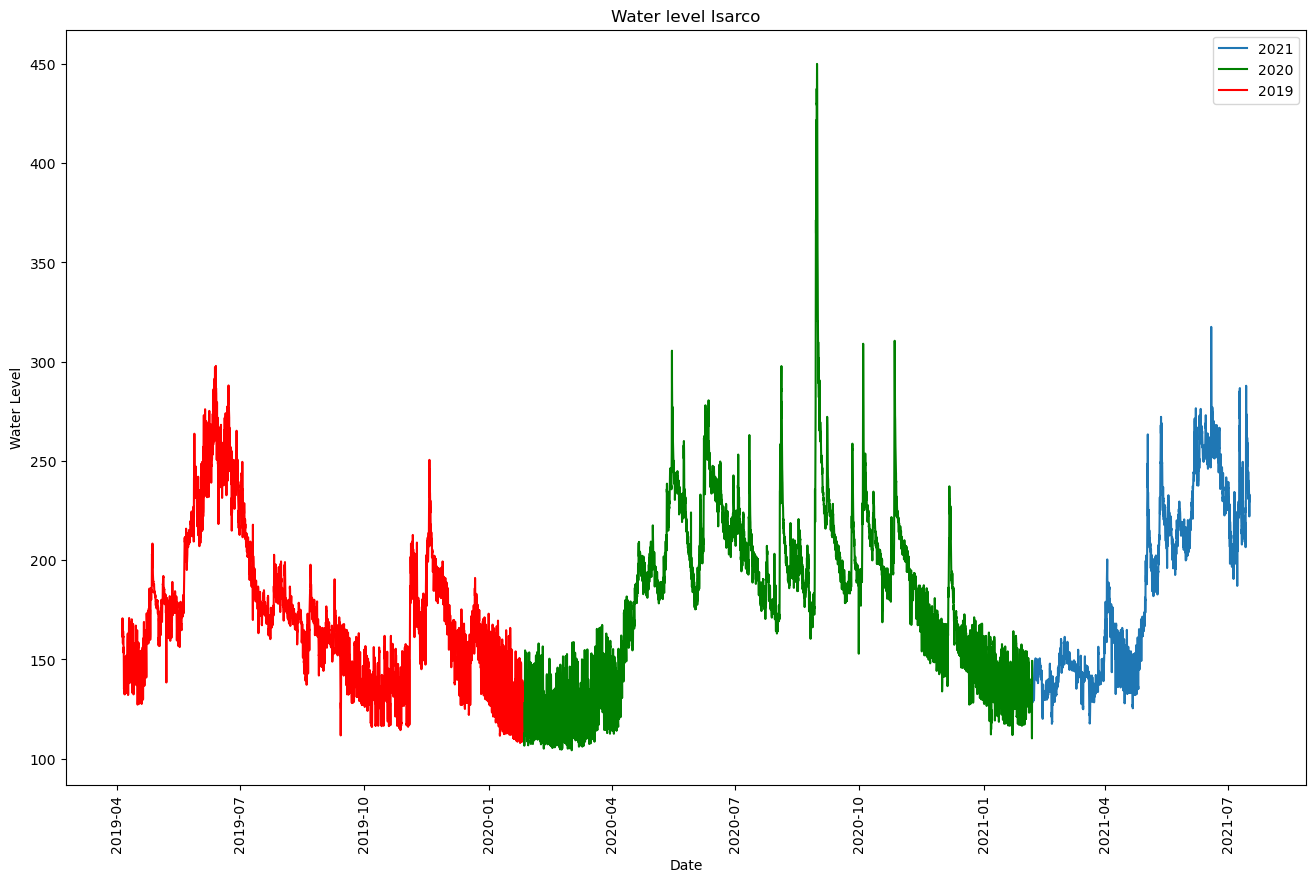

In [14]:
plt.figure(figsize=(16,10), dpi=100)
plt.plot(y_21['Timestamp'], y_21['W_mean'] ,label = '2021')
plt.plot(y_20['Timestamp'], y_20['W_mean'], color = 'green', label= '2020')
plt.plot(y_19['Timestamp'], y_19['W_mean'], color = 'red', label = '2019' )
plt.xlabel('Date')
plt.ylabel('Water Level')
plt.title('Water level Isarco')
plt.xticks(rotation = 'vertical')
plt.legend()
#plt.xticks(df['Timestamp'], rotation = 'vertical')
# MODIFICARE I TICKS 
plt.show()


In [15]:
# Output the maximum and minimum temperature date
print(df.loc[df["W_mean"] == df["W_mean"].max()])
print(df.loc[df["W_mean"] == df["W_mean"].min()])

       index           Timestamp  W_mean
12327  12489 2020-08-30 19:00:00   450.0
      index           Timestamp  W_mean
7976   8138 2020-03-02 08:00:00  104.17


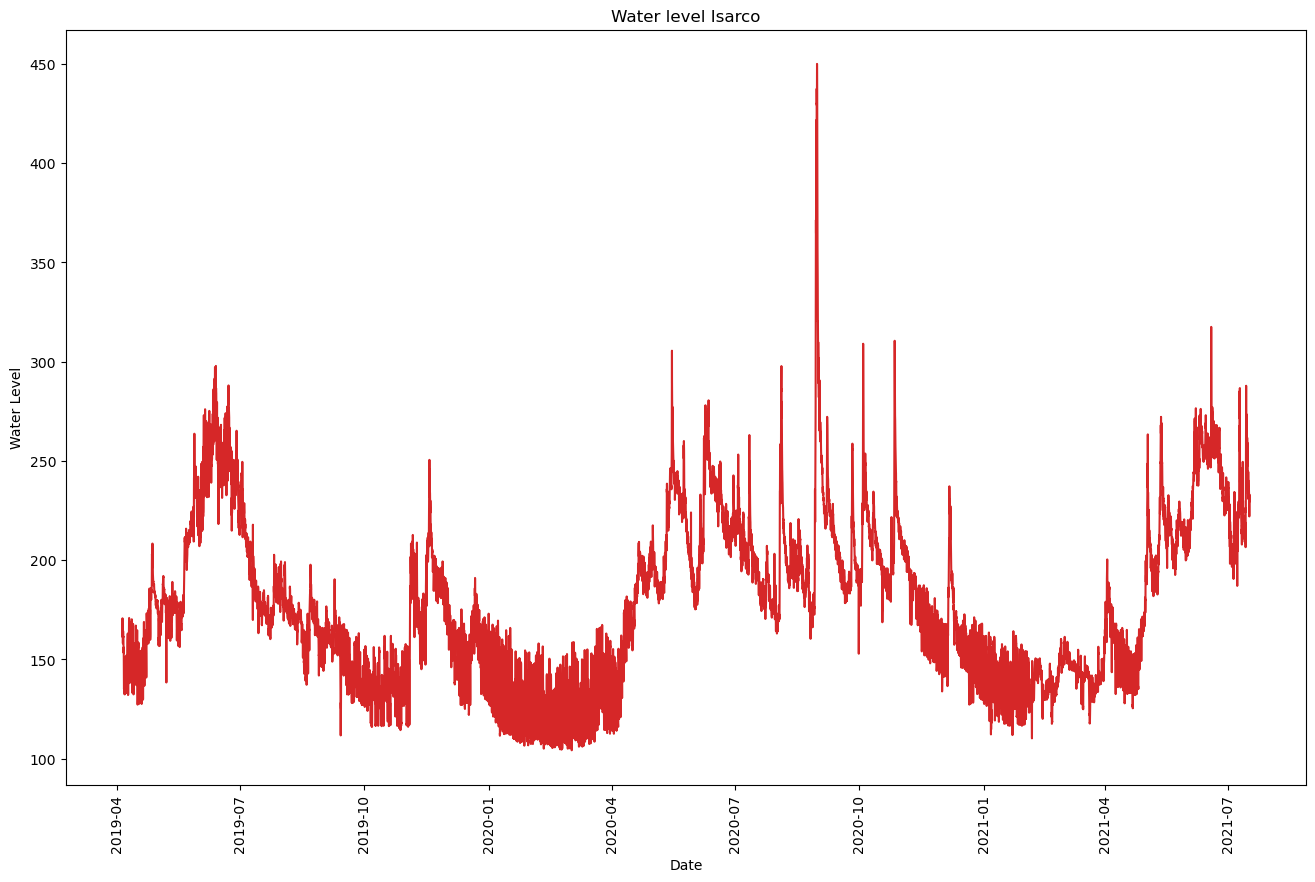

In [16]:
# Plot the daily temperature change 
plt.figure(figsize=(16,10), dpi=100)
plt.plot(df['Timestamp'], df['W_mean'], color='tab:red')
# MODIFICARE I TICKS 
plt.xticks(rotation='vertical')
plt.gca().set(title="Water level Isarco", xlabel='Date', ylabel="Water Level")
plt.show()

<ipython-input-17-934fea2eae33>:4: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result_add = seasonal_decompose(df.W_mean, model='additive', extrapolate_trend='freq', freq=365)


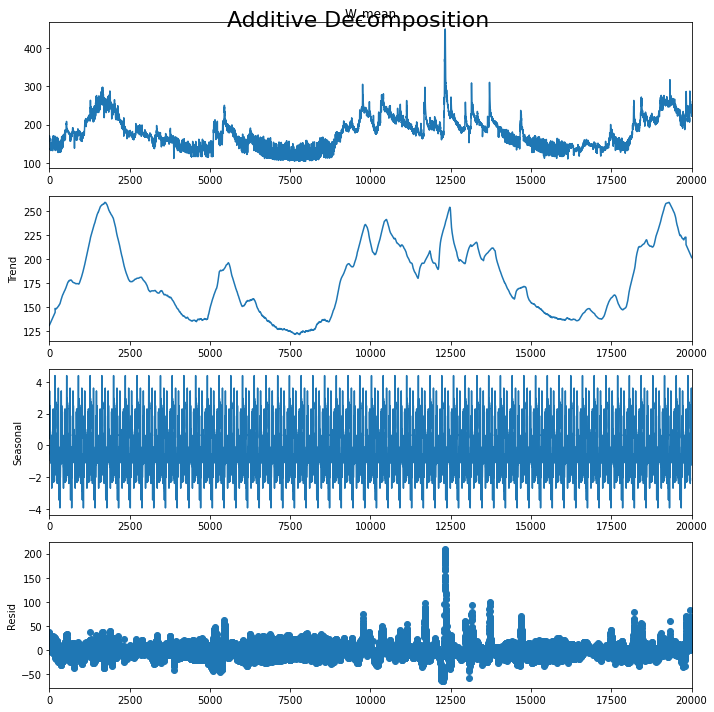

In [17]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Additive Decomposition
result_add = seasonal_decompose(df.W_mean, model='additive', extrapolate_trend='freq', freq=365)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_add.plot().suptitle('Additive Decomposition', fontsize=22)
plt.show()

In [18]:
# Shift the current temperature to the next day. 
predicted_df = df["W_mean"].to_frame().shift(1).rename(columns = {"W_mean": "W_mean_pred" })
actual_df = df["W_mean"].to_frame().rename(columns = {"W_mean": "W_mean_actual" })

# Concatenate the actual and predicted temperature
one_step_df = pd.concat([actual_df,predicted_df],axis=1)

# Select from the second row, because there is no prediction for today due to shifting.
one_step_df = one_step_df[1:]
one_step_df.head(10)


,W_mean_actual,W_mean_pred
1,161.33,162.00
2,163.17,161.33
3,167.33,163.17
4,170.67,167.33
5,169.83,170.67
6,164.50,169.83
7,162.33,164.50
8,162.67,162.33
9,162.50,162.67
10,159.83,162.50


In [19]:
from sklearn.metrics import mean_squared_error as MSE
from math import sqrt

# Calculate the RMSE
temp_pred_err = MSE(one_step_df.W_mean_actual, one_step_df.W_mean_pred, squared=False)
print("The RMSE is",temp_pred_err)

The RMSE is 4.244848842616268


__Weather Forecast using SARIMA model__

In [20]:


import itertools

# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [21]:
import warnings
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(one_step_df.W_mean_actual,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [22]:
# Import the statsmodels library for using SARIMAX model
import statsmodels.api as sm

# Fit the SARIMAX model using optimal parameters
mod = sm.tsa.statespace.SARIMAX(one_step_df.W_mean_actual,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

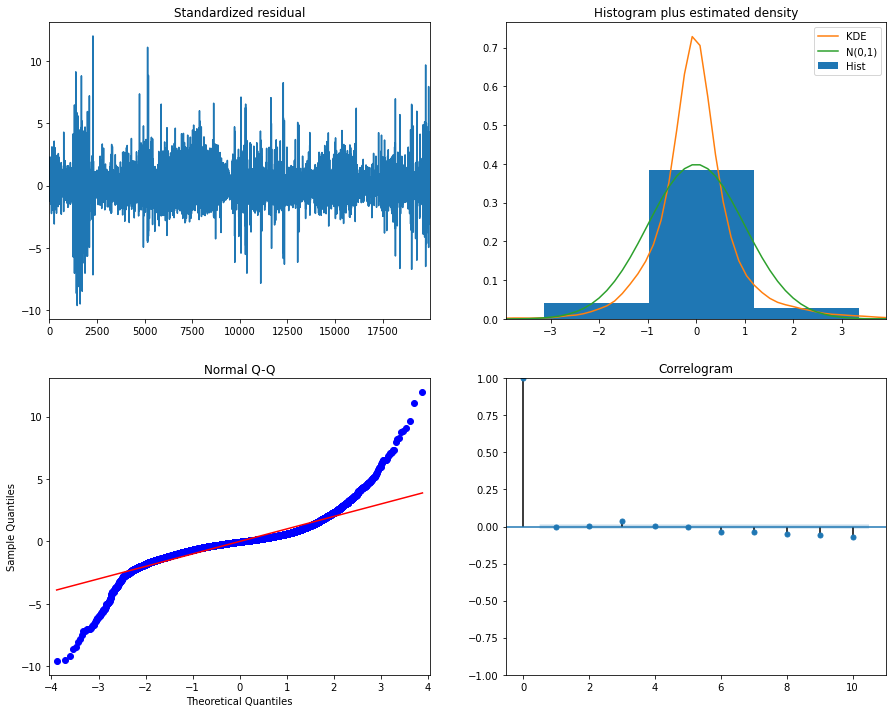

In [23]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
start_pred = len(df)

pred_1h = start_pred +1
pred_3h = start_pred + 3
pred_12h = start_pred +12
pred_1d = start_pred + 24
pred_3d = start_pred + 72
pred_1w = start_pred + 168
pred = results.get_prediction(start = pred_12h , dynamic=False)
pred_ci = pred.conf_int()
print(type(pred_ci)
     )

<class 'pandas.core.frame.DataFrame'>


['213.440191 - 243.834687', '210.529961 - 250.549295', '194.845242 - 262.135367', '183.918981 - 272.593948', '149.720731 - 306.194998', '91.756541 - 362.887025']


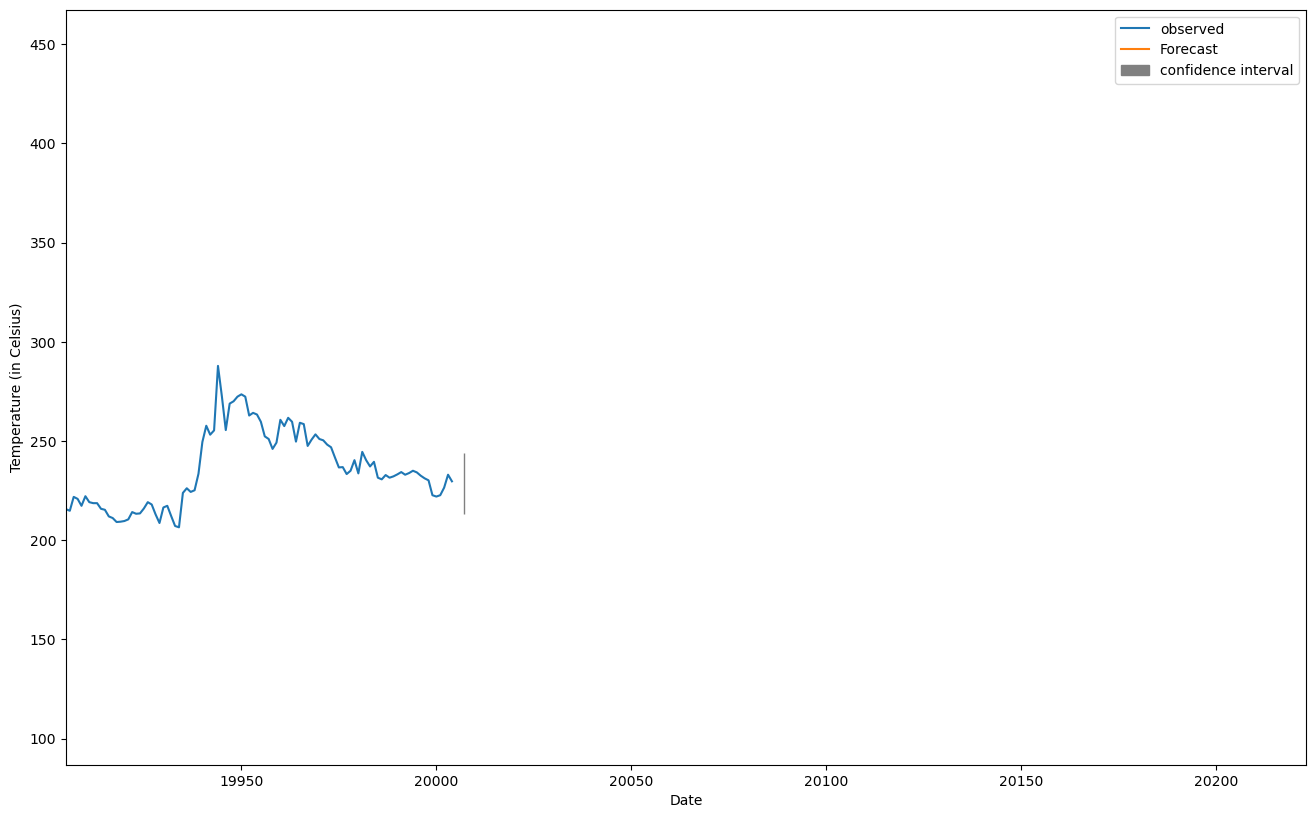

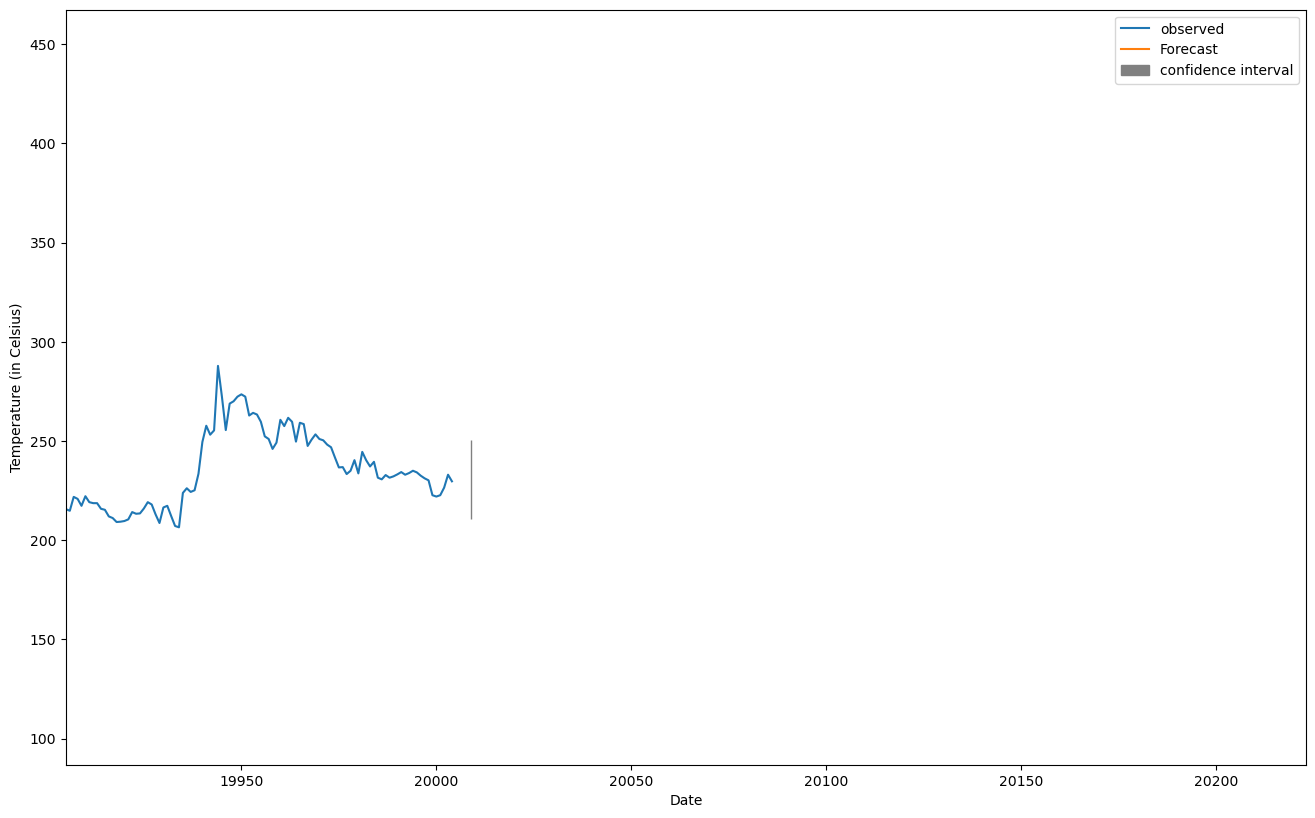

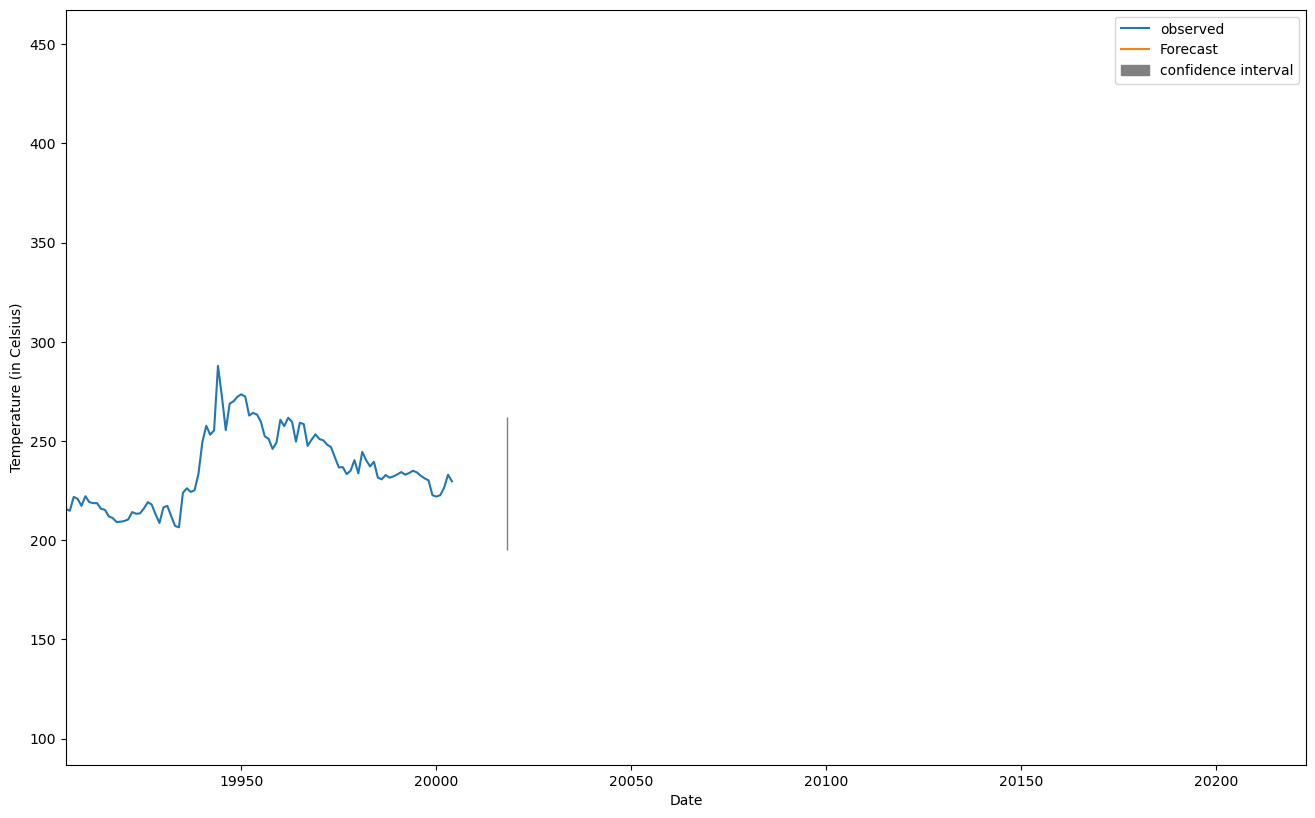

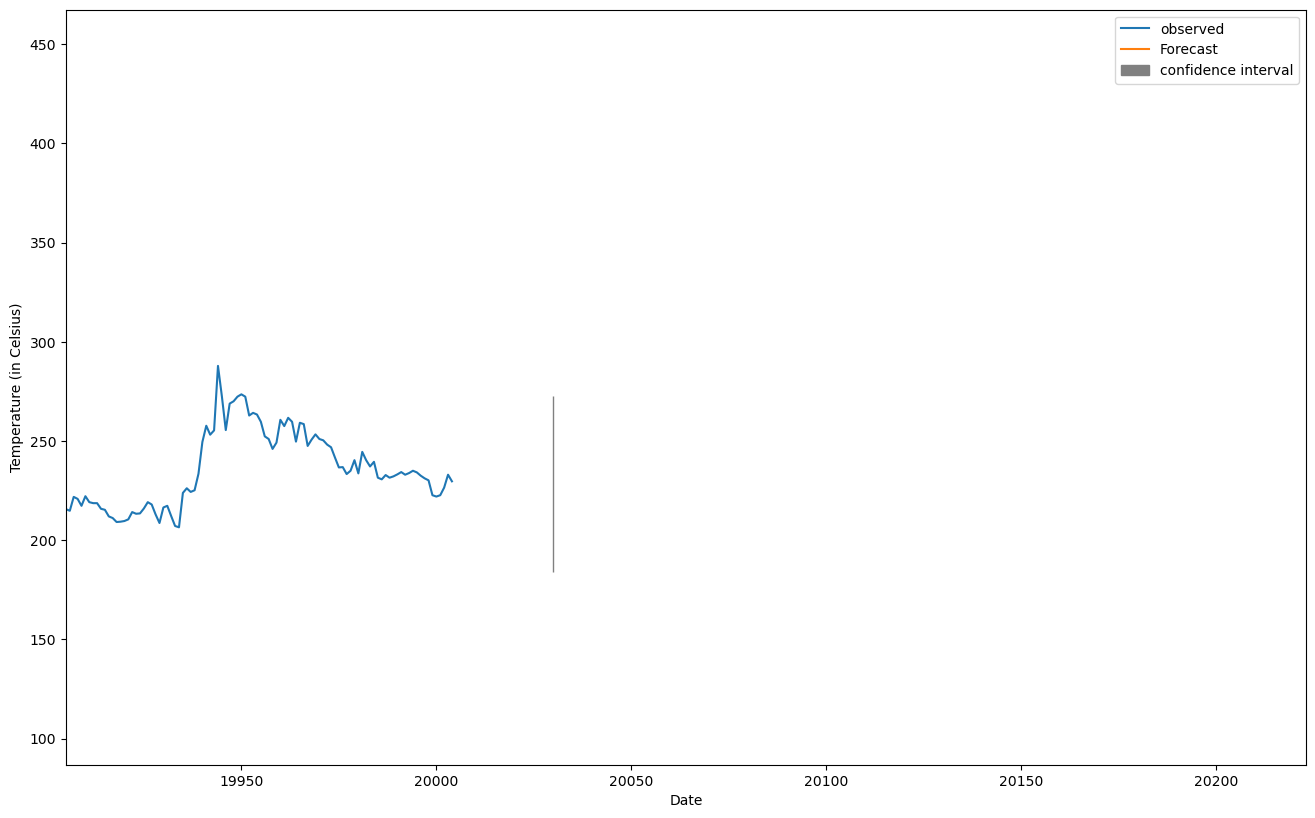

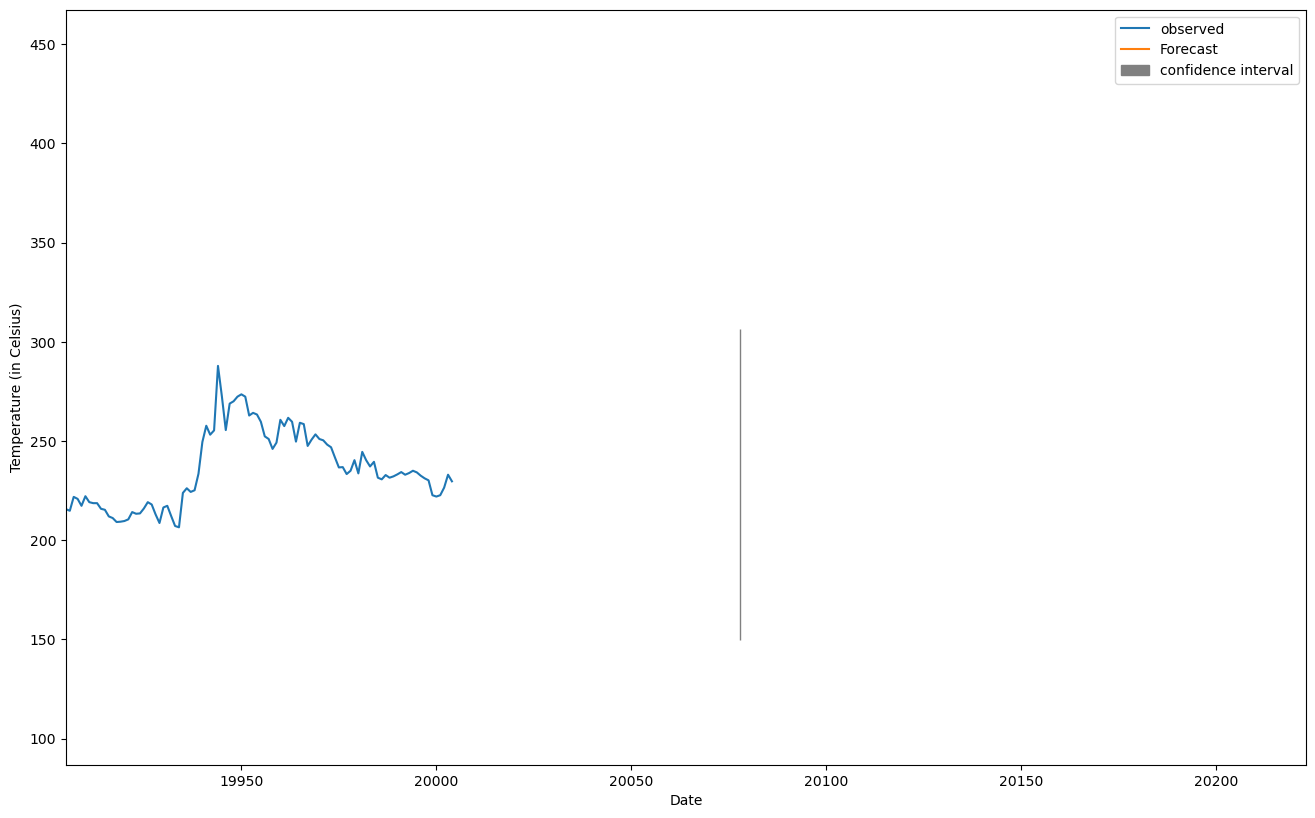

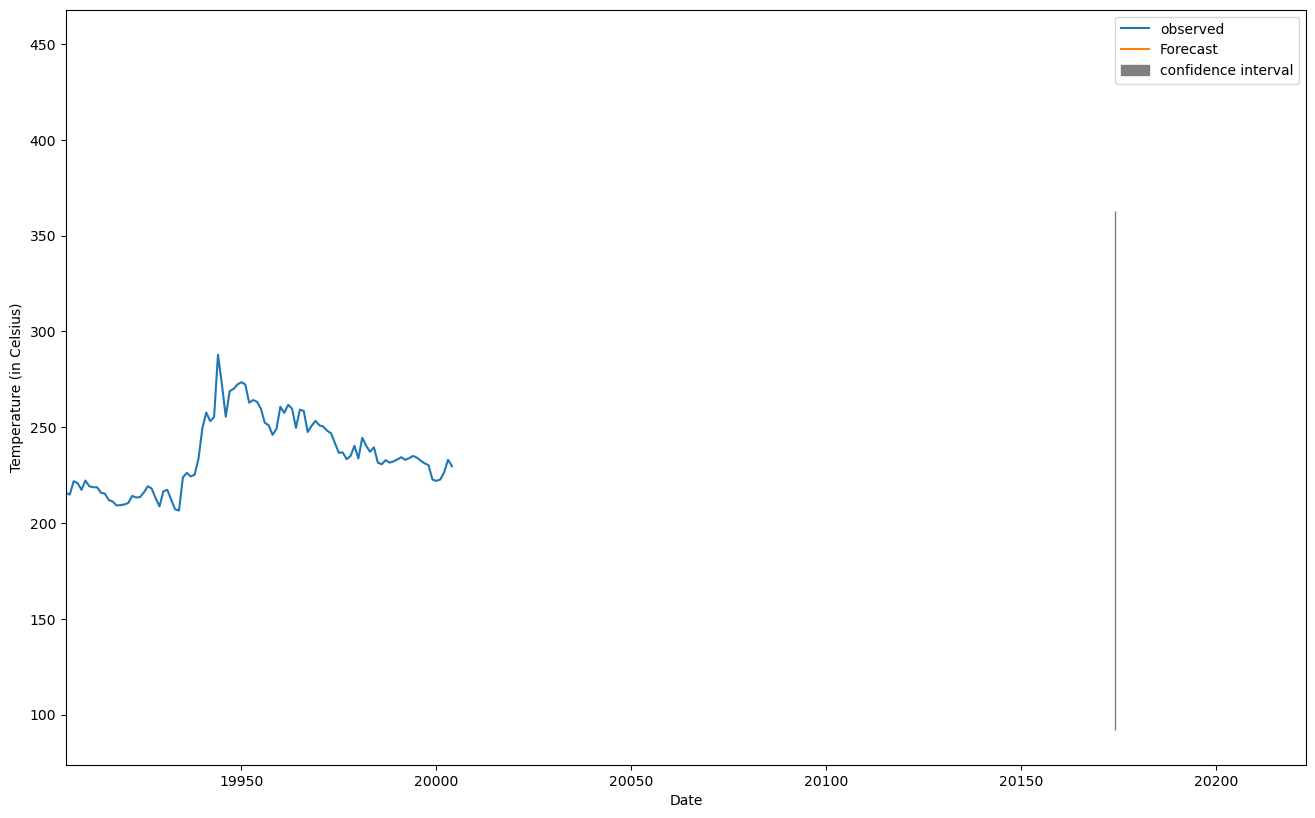

In [34]:
pred_list = [pred_1h,
pred_3h,
pred_12h,
pred_1d,
pred_3d,
pred_1w]
list_output = []
for pred_time in pred_list:
    pred = results.get_prediction(start = pred_time , dynamic=False)
    pred_ci = pred.conf_int()
    output_l = str(pred_ci['lower W_mean_actual']).split()
    output_u = str(pred_ci['upper W_mean_actual']).split()
    #output = str(pred_ci['lower W_mean_actual']) + str(pred_ci['upper W_mean_actual'])
    output = output_l[1] + ' - ' + output_u[1]
    list_output.append(output)
    plt.figure(figsize=(16,10), dpi=100)
    #ax = one_step_df.W_mean_actual[:].plot(label='observed')
    ax = df['W_mean'][:].plot(label='observed')
    pred.predicted_mean.plot(ax=ax, label='Forecast')

    ax.fill_between(pred_ci.index,
                    pred_ci.iloc[:, 0],
                    pred_ci.iloc[:, 1], color='grey', alpha=1, label = 'confidence interval')

    ax.set_xlabel('Date')
    ax.set_ylabel('Temperature (in Celsius)')
    plt.legend()
    plt.xlim([start_pred -100,pred_1w + 50])
    #print(pred_ci.iloc[:, 0])
    #print(pred_ci.iloc[:, 1])
    #plt.show()
print(list_output)


In [33]:
(float(list_output[0].split(' - ')[0]) + float(list_output[0].split(' - ')[1]) )/2
type(pred_ci['lower W_mean_actual'])
 

pandas.core.series.Series

In [30]:
y_forecasted = pred.predicted_mean
print(len(y_forecasted))
y_truth = df.W_mean[16147:]
print(len(y_truth))

1
3847


In [27]:
y_forecasted = pred.predicted_mean
#y_truth = one_step_df.W_mean_actual[16147:]
y_truth = df.W_mean[16147:]
# Compute the mean square error
mse = MSE(y_truth, y_forecasted, squared=True)
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

ValueError: Found input variables with inconsistent numbers of samples: [3847, 1]

In [42]:
print(str(df.iloc[[-1]].Timestamp).split()[1]+' '+str(df.iloc[[-1]].Timestamp).split()[2])

2021-07-15 14:20:00


In [84]:
pred_dynamic = results.get_prediction(start=16147, dynamic=True, full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

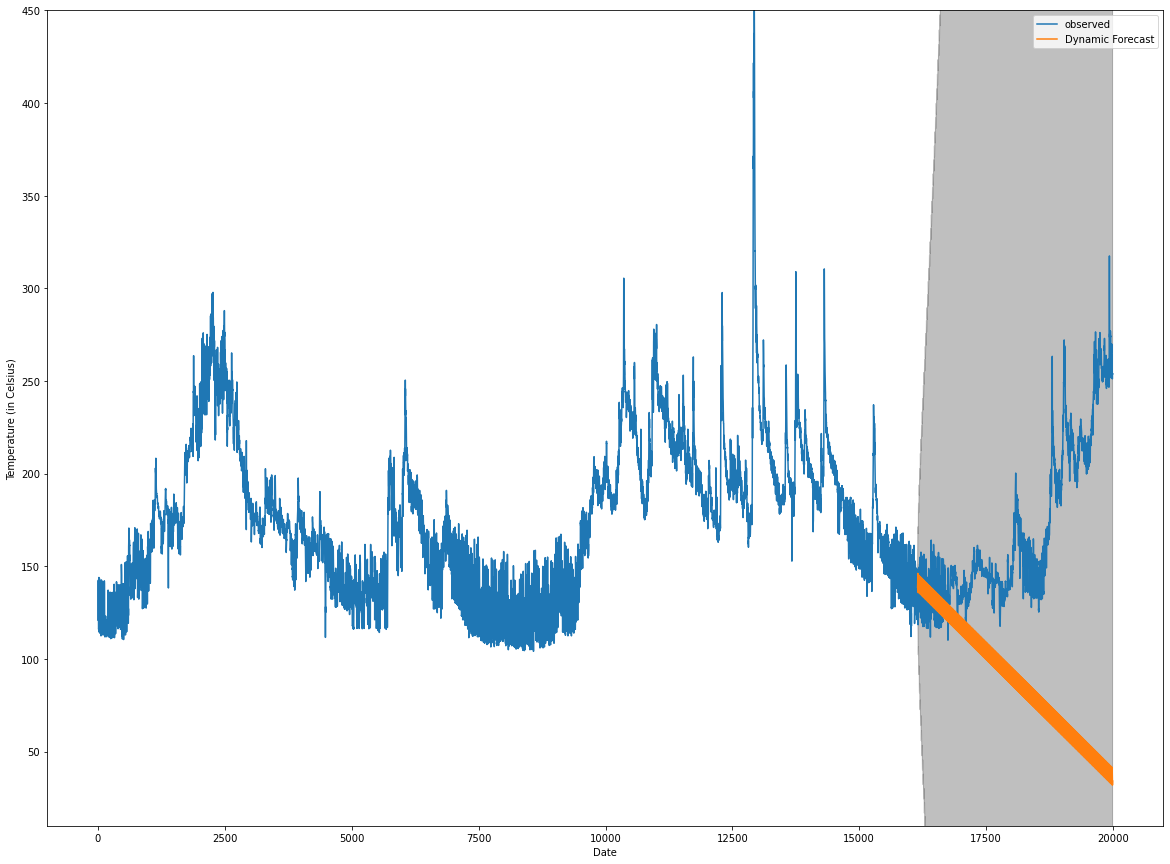

In [85]:
ax = one_step_df.W_mean_actual[:].plot(label='observed', figsize=(20, 15))
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)


ax.set_xlabel('Date')
ax.set_ylabel('Temperature (in Celsius)')
plt.ylim([10,450])
plt.legend()
plt.show()

In [86]:

# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = one_step_df.W_mean_actual[16147:]

# Compute the mean square error
mse = sqrt(MSE(y_truth, y_forecasted).mean())
print('The Root Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Root Mean Squared Error of our forecasts is 108.21
